In [ ]:
#RUN TO TEST DIFFERENT SUBMISSION STRATEGIES BASED ON PROBABILITIES

# import pandas as pd
# import numpy as np
# from pathlib import Path

# OUTPUT_DIR = Path('/drive1/nammt/MALLORN/MALLORN-Challenge/outputs')

# # 1. Load the Probabilities you just generated
# probs_df = pd.read_csv(OUTPUT_DIR / 'probabilities_multiclass_physics.csv')
# tde_probs = probs_df['tde_probability']

# print(f"Max TDE Probability: {tde_probs.max():.4f}")
# print(f"Mean TDE Probability: {tde_probs.mean():.4f}")

# # --- STRATEGY A: AGGRESSIVE THRESHOLD (0.15) ---
# # Since test data is noisy, real TDEs might only score 0.20. 
# # We lower the bar to catch them.
# sub_aggressive = probs_df.copy()
# sub_aggressive['prediction'] = (tde_probs > 0.15).astype(int)
# sub_aggressive[['object_id', 'prediction']].to_csv(OUTPUT_DIR / 'submission_thresh_0.15.csv', index=False)
# print(f"Strategy A (Thresh 0.15): {sub_aggressive['prediction'].sum()} detections")


# # --- STRATEGY B: RANK-BASED (Top 5%) ---
# # We force the model to pick the top 5% most TDE-like objects, 
# # matching the training set prior of ~5%.
# # This ignores the raw probability values and relies on ranking.
# top_k = int(len(probs_df) * 0.05) # Top 5%
# threshold_rank = tde_probs.nlargest(top_k).min()

# sub_rank = probs_df.copy()
# sub_rank['prediction'] = (tde_probs >= threshold_rank).astype(int)
# sub_rank[['object_id', 'prediction']].to_csv(OUTPUT_DIR / 'submission_rank_top5.csv', index=False)
# print(f"Strategy B (Top 5%): {sub_rank['prediction'].sum()} detections (Threshold was {threshold_rank:.4f})")


# # --- STRATEGY C: THE "SWEET SPOT" (0.10) ---
# # If 0.15 is still too strict, we go lower. 
# # In imbalanced learning, Recall > Precision.
# sub_recall = probs_df.copy()
# sub_recall['prediction'] = (tde_probs > 0.10).astype(int)
# sub_recall[['object_id', 'prediction']].to_csv(OUTPUT_DIR / 'submission_thresh_0.10.csv', index=False)
# print(f"Strategy C (Thresh 0.10): {sub_recall['prediction'].sum()} detections")

Max TDE Probability: 0.9199
Mean TDE Probability: 0.0264
Strategy A (Thresh 0.15): 270 detections
Strategy B (Top 5%): 356 detections (Threshold was 0.1083)
Strategy C (Thresh 0.10): 373 detections


In [1]:
"""
MALLORN TDE Classification - Avocado-Style Approach
====================================================
Inspired by the Avocado paper (Boone 2019) for astronomical transient classification.

Key components:
1. Gaussian Process interpolation of multi-band lightcurves
2. Systematic feature extraction from GP predictions
3. Gradient Boosting classification with proper class balancing
"""

import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed
import time
import warnings
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (f1_score, roc_auc_score, precision_recall_curve, 
                             confusion_matrix, classification_report)
import lightgbm as lgb

warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================
BASE_DIR = Path('/drive1/nammt/MALLORN/MALLORN-Challenge/data/raw')
REAL_BASE_DIR = Path('/drive1/nammt/MALLORN/MALLORN-Challenge')
DATA_DIR = REAL_BASE_DIR / 'data/processed'
MODEL_DIR = REAL_BASE_DIR / 'models'
OUTPUT_DIR = REAL_BASE_DIR / 'outputs'
CACHE_DIR = REAL_BASE_DIR / 'cache/gp_models'

# Create directories
for d in [DATA_DIR, MODEL_DIR, OUTPUT_DIR, CACHE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# LSST filter configuration
FILTERS = ['u', 'g', 'r', 'i', 'z', 'y']
FILTER_WAVELENGTHS = {
    'u': 3671, 'g': 4827, 'r': 6223, 
    'i': 7546, 'z': 8691, 'y': 9712
}
FILTER_TO_IDX = {f: i for i, f in enumerate(FILTERS)}

print("="*80)
print("MALLORN TDE Classification - Avocado-Style Pipeline")
print("="*80)
print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Filters: {FILTERS}")
print()

MALLORN TDE Classification - Avocado-Style Pipeline
Base directory: /drive1/nammt/MALLORN/MALLORN-Challenge/data/raw
Output directory: /drive1/nammt/MALLORN/MALLORN-Challenge/outputs
Filters: ['u', 'g', 'r', 'i', 'z', 'y']



In [ ]:
# ============================================================================
# CORE FUNCTIONS: Data Loading & GP Fitting (Avocado-Style)
# ============================================================================

def load_lightcurve(obj_id, split_name, mode='train'):
    """Load lightcurve for a single object from split directory."""
    split_dir = BASE_DIR / split_name
    lc_file = split_dir / f'{mode}_full_lightcurves.csv'
    
    if not lc_file.exists():
        return pd.DataFrame()
    
    lc_full = pd.read_csv(lc_file)
    lc = lc_full[lc_full['object_id'] == obj_id].copy()
    
    if len(lc) == 0:
        return pd.DataFrame()
    
    # Standardize column names
    lc = lc.rename(columns={
        'Time (MJD)': 'mjd',
        'Flux': 'flux', 
        'Flux_err': 'flux_err',
        'Filter': 'band'
    })
    
    return lc[['mjd', 'flux', 'flux_err', 'band']]



def fit_gp_per_band(lc, cache_path=None):
    """
    Fit 2D Gaussian Process in (time, wavelength) space.
    
    This is the true Avocado approach - learns correlations across bands.
    
    Args:
        lc: DataFrame with mjd, flux, flux_err, band columns
        cache_path: Optional path to cache results
        
    Returns:
        dict with GP model and predictions on 2D grid
    """
    # Check cache with version validation
    if cache_path and cache_path.exists():
        try:
            cached = joblib.load(cache_path)
            # Validate it's 2D GP format (has 't_grid' key)
            if isinstance(cached, dict) and 't_grid' in cached:
                return cached
            else:
                # Outdated cache, will refit
                pass
        except:
            pass
    
    if len(lc) < 10:  # Need more data for 2D GP
        return None
    
    # ====== ADD DATA VALIDATION ======
    # Remove rows with NaN/inf values
    lc_clean = lc.copy()
    lc_clean = lc_clean.dropna(subset=['mjd', 'flux', 'flux_err', 'band'])
    
    # Remove infinite values
    lc_clean = lc_clean[
        np.isfinite(lc_clean['flux']) & 
        np.isfinite(lc_clean['flux_err']) &
        np.isfinite(lc_clean['mjd'])
    ]
    
    # Remove zero or negative flux errors
    lc_clean = lc_clean[lc_clean['flux_err'] > 0]
    
    # Check if we still have enough data
    if len(lc_clean) < 10:
        return None
    
    # Prepare 2D input: (time, wavelength)
    t = lc_clean['mjd'].values
    t_ref = t.min()
    t_norm = t - t_ref
    
    # Convert band to wavelength (in Angstroms)
    wavelengths = lc_clean['band'].map(FILTER_WAVELENGTHS).values
    
    # Check for unmapped bands
    if np.isnan(wavelengths).any():
        # Remove unmapped bands
        valid_bands = ~np.isnan(wavelengths)
        t_norm = t_norm[valid_bands]
        wavelengths = wavelengths[valid_bands]
        lc_clean = lc_clean[valid_bands]
        
        if len(lc_clean) < 10:
            return None
    
    # Normalize wavelength to ~0-1 range for numerical stability
    wl_min, wl_max = 3000, 10000
    wl_norm = (wavelengths - wl_min) / (wl_max - wl_min)
    
    # 2D input array
    X = np.column_stack([t_norm, wl_norm])
    
    # Outputs
    flux = lc_clean['flux'].values
    flux_err = np.clip(lc_clean['flux_err'].values, 0.01, None)
    
    # Final validation
    if np.isnan(flux).any() or np.isnan(flux_err).any() or np.isnan(X).any():
        return None
    
    # 2D Kernel: Product of temporal and spectral kernels
    kernel = (
        ConstantKernel(1.0, (1e-3, 1e3)) * 
        RBF(
            length_scale=[20.0, 0.2],  # [time, wavelength]
            length_scale_bounds=[(1.0, 200.0), (0.05, 0.5)]
        ) +
        WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e2))
    )
    
    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=flux_err**2,
        n_restarts_optimizer=2,
        normalize_y=True,
        random_state=RANDOM_SEED
    )
    
    try:
        gp.fit(X, flux)
        
        # Create 2D prediction grid: time × wavelength
        t_grid = np.linspace(0, t_norm.max(), 50)
        wl_grid_norm = np.linspace(0, 1, 6)
        
        # All combinations
        T_grid, WL_grid = np.meshgrid(t_grid, wl_grid_norm, indexing='ij')
        X_pred = np.column_stack([T_grid.ravel(), WL_grid.ravel()])
        
        # Predict
        flux_pred, flux_std = gp.predict(X_pred, return_std=True)
        
        # Reshape to (n_times, n_bands)
        flux_pred_2d = flux_pred.reshape(len(t_grid), len(wl_grid_norm))
        flux_std_2d = flux_std.reshape(len(t_grid), len(wl_grid_norm))
        
        # Convert normalized wavelengths back to band names
        wl_actual = wl_grid_norm * (wl_max - wl_min) + wl_min
        bands_grid = []
        for wl in wl_actual:
            closest_band = min(FILTER_WAVELENGTHS.keys(), 
                             key=lambda b: abs(FILTER_WAVELENGTHS[b] - wl))
            bands_grid.append(closest_band)
        
        result = {
            'gp': gp,
            't_ref': t_ref,
            't_grid': t_grid + t_ref,
            'bands_grid': bands_grid,
            'flux_2d': flux_pred_2d,
            'flux_std_2d': flux_std_2d,
            't_obs': t,
            'flux_obs': flux,
            'flux_err_obs': flux_err,
            'bands_obs': lc_clean['band'].values
        }
        
        # Cache the result
        if cache_path:
            joblib.dump(result, cache_path)
        
        return result
        
    except Exception as e:
        # Suppress individual errors (already printed)
        return None


def fit_multiband_gp(lc, cache_path=None):
    """
    Wrapper to call 2D GP fitting.
    Kept for backward compatibility.
    """
    return fit_gp_per_band(lc, cache_path)

# def fit_gp_per_band(lc, band):
#     """
#     Fit 1D Gaussian Process to a single band's lightcurve.
    
#     Args:
#         lc: DataFrame with mjd, flux, flux_err columns
#         band: filter name ('u', 'g', 'r', 'i', 'z', 'y')
    
#     Returns:
#         dict with GP model and predictions, or None if insufficient data
#     """
#     band_lc = lc[lc['band'] == band].copy()
    
#     if len(band_lc) < 3:
#         return None
    
#     # Normalize time to start at 0
#     t = band_lc['mjd'].values
#     t_ref = t.min()
#     t_norm = t - t_ref
    
#     flux = band_lc['flux'].values
#     flux_err = band_lc['flux_err'].values
    
#     # Handle edge cases
#     flux_err = np.clip(flux_err, 0.01, None)
    
#     # Avocado-style kernel: Matern + WhiteKernel for noise
#     # Length scale ~ 20-50 days for transients
#     kernel = (
#         ConstantKernel(1.0, (1e-3, 1e3)) * 
#         Matern(length_scale=20.0, length_scale_bounds=(1, 500), nu=1.5) +
#         WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e2))
#     )
    
#     gp = GaussianProcessRegressor(
#         kernel=kernel,
#         alpha=flux_err**2,  # Observation noise
#         n_restarts_optimizer=3,
#         normalize_y=True,
#         random_state=RANDOM_SEED
#     )
    
#     try:
#         gp.fit(t_norm.reshape(-1, 1), flux)
        
#         # Predict on regular grid
#         t_pred = np.linspace(0, t_norm.max(), 100)
#         flux_pred, flux_std = gp.predict(t_pred.reshape(-1, 1), return_std=True)
        
#         return {
#             'gp': gp,
#             't_ref': t_ref,
#             't_pred': t_pred + t_ref,
#             'flux_pred': flux_pred,
#             'flux_std': flux_std,
#             't_obs': t,
#             'flux_obs': flux,
#             'flux_err_obs': flux_err
#         }
#     except Exception as e:
#         return None


def fit_multiband_gp(lc, cache_path=None):
    """
    Wrapper to call 2D GP fitting.
    Kept for backward compatibility.
    """
    # fit_gp_per_band handles caching internally
    return fit_gp_per_band(lc, cache_path)


def extract_avocado_features(gp_results, obj_id):
    """
    Extract features from 2D GP predictions.
    
    Now works with 2D GP output: (time, wavelength) grid.
    """
    if gp_results is None:
        return {'object_id': obj_id}
    
    features = {'object_id': obj_id}
    
    # Extract 2D predictions
    t_grid = gp_results['t_grid']
    bands_grid = gp_results['bands_grid']
    flux_2d = gp_results['flux_2d']  # Shape: (n_times, n_bands)
    flux_std_2d = gp_results['flux_std_2d']
    
    # ========================================================================
    # Per-band features (extract from 2D grid)
    # ========================================================================
    
    band_peaks = {}
    band_peak_times = {}
    band_amplitudes = {}
    
    for i, band in enumerate(bands_grid):
        flux_band = flux_2d[:, i]
        flux_std_band = flux_std_2d[:, i]
        
        # Peak properties
        peak_idx = np.argmax(flux_band)
        peak_flux = flux_band[peak_idx]
        peak_time = t_grid[peak_idx]
        
        
        band_peaks[band] = peak_flux
        band_peak_times[band] = peak_time
        
        features[f'{band}_peak_flux'] = peak_flux
        features[f'{band}_peak_time'] = peak_time
        features[f'{band}_peak_uncertainty'] = flux_std_band[peak_idx]
        
        # Amplitude
        amplitude = flux_band.max() - flux_band.min()
        band_amplitudes[band] = amplitude
        features[f'{band}_amplitude'] = amplitude
        
        # Statistics
        features[f'{band}_mean_flux'] = np.mean(flux_band)
        features[f'{band}_std_flux'] = np.std(flux_band)
        
        if np.std(flux_band) > 0:
            features[f'{band}_skewness'] = ((flux_band - np.mean(flux_band))**3).mean() / (np.std(flux_band)**3 + 1e-10)
        
        # Rise/decline times
        threshold = 0.2 * peak_flux + 0.8 * flux_band.min()
        pre_peak = flux_band[:peak_idx]
        if len(pre_peak) > 0:
            rise_mask = pre_peak >= threshold
            if rise_mask.any():
                rise_start_idx = np.where(rise_mask)[0][0]
                features[f'{band}_rise_time'] = t_grid[peak_idx] - t_grid[rise_start_idx]
        
        post_peak = flux_band[peak_idx:]
        if len(post_peak) > 1:
            half_peak = 0.5 * peak_flux
            decline_mask = post_peak <= half_peak
            if decline_mask.any():
                decline_idx = np.where(decline_mask)[0][0]
                features[f'{band}_decline_time'] = t_grid[peak_idx + decline_idx] - t_grid[peak_idx]
        
        features[f'{band}_gp_smoothness'] = np.mean(flux_std_band)
        
        # Observation stats
        band_obs = gp_results['bands_obs'] == band
        if band_obs.any():
            features[f'{band}_n_obs'] = band_obs.sum()
            t_obs_band = gp_results['t_obs'][band_obs]
            features[f'{band}_time_span'] = t_obs_band.max() - t_obs_band.min()
    
    # ========================================================================
    # NEW: Cross-band features from 2D GP (key advantage!)
    # ========================================================================
    
    # Colors at multiple epochs (not just peak)
    color_pairs = [('u', 'g'), ('g', 'r'), ('r', 'i'), ('i', 'z'), ('u', 'r'), ('g', 'i')]
    
    for b1, b2 in color_pairs:
        if b1 in bands_grid and b2 in bands_grid:
            i1 = bands_grid.index(b1)
            i2 = bands_grid.index(b2)
            
            flux_b1 = flux_2d[:, i1]
            flux_b2 = flux_2d[:, i2]
            
            # Color at peak of b1
            peak_idx_b1 = np.argmax(flux_b1)
            if flux_b1[peak_idx_b1] > 0 and flux_b2[peak_idx_b1] > 0:
                features[f'color_{b1}_{b2}_peak'] = -2.5 * np.log10(
                    flux_b1[peak_idx_b1] / flux_b2[peak_idx_b1]
                )
            
            # Color evolution (time series of colors)
            valid = (flux_b1 > 0) & (flux_b2 > 0)
            if valid.sum() > 10:
                colors = -2.5 * np.log10(flux_b1[valid] / flux_b2[valid])
                t_valid = t_grid[valid]
                
                # Early, middle, late colors
                n_valid = len(colors)
                features[f'color_{b1}_{b2}_early'] = np.mean(colors[:n_valid//3])
                features[f'color_{b1}_{b2}_mid'] = np.mean(colors[n_valid//3:2*n_valid//3])
                features[f'color_{b1}_{b2}_late'] = np.mean(colors[-n_valid//3:])
                
                # Color range (total change)
                features[f'color_{b1}_{b2}_range'] = colors.max() - colors.min()
                
                # Color evolution rate
                if len(t_valid) > 5:
                    try:
                        slope, _ = np.polyfit(t_valid - t_valid.min(), colors, 1)
                        features[f'color_{b1}_{b2}_evolution'] = slope
                    except:
                        pass
    
    # Blue excess (critical for TDEs!)
    if 'u' in bands_grid and 'g' in bands_grid:
        i_u = bands_grid.index('u')
        i_g = bands_grid.index('g')
        
        flux_u = flux_2d[:, i_u]
        flux_g = flux_2d[:, i_g]
        
        valid = (flux_u > 0) & (flux_g > 0)
        if valid.any():
            blue_excess_series = -2.5 * np.log10(flux_u[valid] / flux_g[valid])
            features['blue_excess_mean'] = np.mean(blue_excess_series)
            features['blue_excess_min'] = np.min(blue_excess_series)
            features['blue_excess_max'] = np.max(blue_excess_series)
    
    # Spectral slope at peak (NEW!)
    # Fit power law to SED at peak time
    peak_time_global = np.median([band_peak_times[b] for b in band_peak_times])
    peak_time_idx = np.argmin(np.abs(t_grid - peak_time_global))
    
    flux_at_peak = flux_2d[peak_time_idx, :]
    wavelengths_at_peak = [FILTER_WAVELENGTHS[b] for b in bands_grid]
    
    valid_sed = flux_at_peak > 0
    if valid_sed.sum() >= 3:
        log_flux = np.log10(flux_at_peak[valid_sed])
        log_wl = np.log10(np.array(wavelengths_at_peak)[valid_sed])
        
        try:
            slope, _ = np.polyfit(log_wl, log_flux, 1)
            features['spectral_slope_at_peak'] = slope
            # TDEs: blue spectrum → positive slope (flux increases with λ is wrong, should be negative)
            # Actually: F_ν ∝ ν^α → F_λ ∝ λ^(-α-2)
            # Blue sources have negative spectral index in F_λ
        except:
            pass
    
    # Peak time differences (chromatic lag)
    if len(band_peak_times) >= 2:
        peak_times_arr = np.array(list(band_peak_times.values()))
        features['peak_time_range'] = peak_times_arr.max() - peak_times_arr.min()
        
        if 'u' in band_peak_times and 'r' in band_peak_times:
            features['u_r_peak_delay'] = band_peak_times['r'] - band_peak_times['u']
        
        if 'g' in band_peak_times and 'i' in band_peak_times:
            features['g_i_peak_delay'] = band_peak_times['i'] - band_peak_times['g']
    
    # Amplitude ratios
    if 'u' in band_amplitudes and 'r' in band_amplitudes and band_amplitudes['r'] > 0:
        features['amplitude_ratio_u_r'] = band_amplitudes['u'] / band_amplitudes['r']
    
    if 'g' in band_amplitudes and 'i' in band_amplitudes and band_amplitudes['i'] > 0:
        features['amplitude_ratio_g_i'] = band_amplitudes['g'] / band_amplitudes['i']
    
    # Global features
    features['total_peak_flux'] = sum(band_peaks.values())
    features['n_bands_detected'] = len(bands_grid)
    
    # GP quality metrics
    features['gp_mean_uncertainty'] = np.mean(flux_std_2d)
    features['gp_max_uncertainty'] = np.max(flux_std_2d)
    
    return features


print("✓ Core functions loaded:")
print("  - load_lightcurve()")
print("  - fit_gp_per_band()")
print("  - fit_multiband_gp()")
print("  - extract_avocado_features()")
print()

✓ Core functions loaded:
  - load_lightcurve()
  - fit_gp_per_band()
  - fit_multiband_gp()
  - extract_avocado_features()



In [2]:
# ============================================================================
# CELL 3: PROCESS FULL TRAINING SET
# ============================================================================
print("="*80)
print("CELL 3: Processing Training Set")
print("="*80)

# Load metadata
train_log = pd.read_csv(BASE_DIR / 'train_log.csv')
print(f"Total training objects: {len(train_log)}")
print(f"  TDEs (target=1): {train_log['target'].sum()}")
print(f"  Non-TDEs (target=0): {(train_log['target']==0).sum()}")
print(f"  Class imbalance: {train_log['target'].mean()*100:.2f}% TDE")
print()

def process_single_object(row, mode='train'):
    """Process a single object: load LC -> fit GP -> extract features."""
    obj_id = row['object_id']
    cache_path = CACHE_DIR / f"{obj_id}_gp.pkl"
    
    # Load lightcurve
    lc = load_lightcurve(obj_id, row['split'], mode)
    
    if len(lc) < 5:
        # Insufficient data - return basic info only
        result = {'object_id': obj_id}
        if mode == 'train':
            result['target'] = row['target']
        result['Z'] = row['Z']
        result['EBV'] = row['EBV']
        result['has_lc'] = 0
        return result
    
    # Fit multi-band GP
    gp_results = fit_multiband_gp(lc, cache_path)
    
    # Extract features
    features = extract_avocado_features(gp_results, obj_id)
    
    # Add metadata
    if mode == 'train':
        features['target'] = row['target']
    features['Z'] = row['Z']
    features['EBV'] = row['EBV']
    features['has_lc'] = 1 if gp_results else 0
    
    return features

# Check for cached features
train_features_path = DATA_DIR / 'train_avocado_features.csv'

if train_features_path.exists():
    print(f"✓ Loading cached training features from {train_features_path}")
    train_features = pd.read_csv(train_features_path)
    print(f"  Shape: {train_features.shape}")
else:
    print("Processing training set with GP fitting...")
    print("This may take 30-60 minutes depending on hardware.")
    print()
    
    start_time = time.time()
    
    # Process in parallel
    results = Parallel(n_jobs=8, verbose=10)(
        delayed(process_single_object)(row, mode='train')
        for _, row in train_log.iterrows()
    )
    
    elapsed = time.time() - start_time
    print(f"\n✓ Processing completed in {elapsed/60:.1f} minutes")
    
    # Create DataFrame
    train_features = pd.DataFrame(results)
    
    # Save
    train_features.to_csv(train_features_path, index=False)
    print(f"✓ Saved to {train_features_path}")

# Summary
print(f"\nTraining features summary:")
print(f"  Total samples: {len(train_features)}")
print(f"  Total features: {len(train_features.columns)}")
print(f"  TDEs: {train_features['target'].sum()}")

# Check feature coverage
feature_cols = [c for c in train_features.columns if c not in ['object_id', 'target', 'Z', 'EBV', 'has_lc']]
non_null_pct = train_features[feature_cols].notna().mean().mean() * 100
print(f"  Feature coverage: {non_null_pct:.1f}%")
print()

CELL 3: Processing Training Set
Total training objects: 3043
  TDEs (target=1): 148
  Non-TDEs (target=0): 2895
  Class imbalance: 4.86% TDE

✓ Loading cached training features from /drive1/nammt/MALLORN/MALLORN-Challenge/data/processed/train_avocado_features.csv
  Shape: (3043, 126)

Training features summary:
  Total samples: 3043
  Total features: 126
  TDEs: 148
  Feature coverage: 98.4%



In [6]:
# ============================================================================
# CELL 4: FIXED TDE AUGMENTATION (Physics-Only Filter)
# ============================================================================
print("="*80)
print("CELL 4: TDE Augmentation (Physics Constraints Only)")
print("="*80)

def augment_tde_features(tde_row, n_augmentations=3):
    """Conservative augmentation preserving TDE physics"""
    augmented = []
    
    for i in range(n_augmentations):
        aug = tde_row.copy()
        aug['object_id'] = f"{tde_row['object_id']}_aug_{i}"
        aug['is_augmented'] = 1
        
        # 1. Redshift Scaling (Physics)
        z_scale = np.random.uniform(0.95, 1.15)
        for col in aug.index:
            if 'flux' in col or 'amplitude' in col:
                aug[col] *= z_scale**(-2)
            elif ('rise' in col or 'decline' in col) and 'delay' not in col:
                aug[col] *= z_scale
        
        # 2. Add Noise (5%)
        for col in aug.index:
            if col in ['object_id', 'target', 'is_augmented', 'Z', 'EBV', 'SpecType']:
                continue
            if pd.notna(aug[col]) and isinstance(aug[col], (int, float)):
                 # Scale noise by the value itself
                noise = np.random.normal(0, abs(aug[col]) * 0.05)
                aug[col] += noise
                
        augmented.append(aug)
    return augmented

def filter_invalid_tdes(df):
    """
    Remove ONLY samples that violate laws of physics.
    Do NOT remove statistical outliers (let the model handle those).
    """
    # Only check augmented rows
    aug_mask = df['is_augmented'] == 1
    valid_aug = pd.Series(True, index=df.index)
    
    # RULE 1: Negative Flux is impossible for Peak Flux
    # (GP sometimes predicts negative flux if data is noisy, but we can't train on it)
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        col = f'{band}_peak_flux'
        if col in df.columns:
            # Mark invalid if peak flux is negative (unphysical)
            valid_aug &= ~((aug_mask) & (df[col] < 0))

    # RULE 2: TDEs must stay TDE-colored (Blue Excess shouldn't flip to Red)
    # If we have blue_excess features, ensure they don't become massive outliers
    if 'blue_excess_min' in df.columns:
        # A TDE shouldn't look like a cool Red Giant. 
        # But we be lenient: only remove if it's > 2.0 (very red)
        valid_aug &= ~((aug_mask) & (df['blue_excess_min'] > 2.0))

    removed = (~valid_aug).sum()
    print(f"Removed {removed} physically invalid samples ({(removed/len(df))*100:.2f}%)")
    
    return df[valid_aug].reset_index(drop=True)

# --- EXECUTION ---

# 1. Load Data & SpecType
# Ensure we have the SpecType merged
if 'SpecType' not in train_features.columns:
    train_log = pd.read_csv(REAL_BASE_DIR / 'data/raw/train_log.csv')
    train_features = train_features.merge(train_log[['object_id', 'SpecType']], on='object_id', how='left')

tdes = train_features[train_features['target'] == 1].copy()
non_tdes = train_features[train_features['target'] == 0].copy()

# 2. Target a healthy ratio (1:4)
target_tde_count = len(non_tdes) // 4
n_aug = max(1, (target_tde_count - len(tdes)) // len(tdes))

print(f"Augmenting {len(tdes)} TDEs x {n_aug} times...")

# 3. Generate
all_aug = []
for _, row in tqdm(tdes.iterrows(), total=len(tdes)):
    all_aug.extend(augment_tde_features(row, n_augmentations=n_aug))

# 4. Merge & Filter
aug_df = pd.DataFrame(all_aug)
train_features['is_augmented'] = 0

# Align columns
for c in train_features.columns:
    if c not in aug_df.columns: aug_df[c] = np.nan

train_balanced = pd.concat([train_features, aug_df], ignore_index=True)
train_balanced = filter_invalid_tdes(train_balanced)

print(f"\nFinal Stats:")
print(f"  Real TDEs: {len(tdes)}")
print(f"  Augmented TDEs: {len(train_balanced) - len(train_features)}")
print(f"  Total Rows: {len(train_balanced)}")

# Save
train_balanced.to_csv(DATA_DIR / 'train_balanced_avocado.csv', index=False)
print("✓ Saved repaired dataset.")

CELL 4: TDE Augmentation (Physics Constraints Only)
Augmenting 148 TDEs x 3 times...


  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:01<00:00, 103.80it/s]


Removed 0 physically invalid samples (0.00%)

Final Stats:
  Real TDEs: 148
  Augmented TDEs: 444
  Total Rows: 3487
✓ Saved repaired dataset.


In [ ]:
# ============================================================================
# CELL 5: PHYSICS-BASED FEATURE ENGINEERING
# ============================================================================
print("="*80)
print("CELL 5: Physical Feature Engineering + Preprocessing")
print("="*80)

def apply_physics_corrections(df):
    """
    Apply cosmological and physical corrections to features
    """
  
    df = df.copy()
    
    # 1. RELATIVE TIMING
    if 'r_peak_time' in df.columns:
        for band in ['u', 'g', 'i', 'z', 'y']:
            col = f'{band}_peak_time'
            if col in df.columns:
                df[f'{band}_r_peak_delay'] = df[col] - df['r_peak_time']
        # Drop absolute peak times
        df = df.drop(columns=[c for c in df.columns if '_peak_time' in c], errors='ignore')
    
    # 2. REST-FRAME TIME (Avoid double _rest)
    # Target original time columns only
    orig_time_cols = [c for c in df.columns if any(x in c for x in ['rise', 'decline', 'span', 'delay']) 
                      and not c.endswith('_rest')]
    for col in orig_time_cols:
        df[f'{col}_rest'] = df[col] / (1 + df['Z'])
    df = df.drop(columns=orig_time_cols, errors='ignore')

    # 3. LUMINOSITY (Avoid double _luminosity)
    orig_flux_cols = [c for c in df.columns if any(x in c for x in ['peak_flux', 'amplitude', 'mean_flux']) 
                      and not c.endswith('_luminosity')]
    for col in orig_flux_cols:
        df[f'{col}_luminosity'] = df[col] * (1 + df['Z'])**2
    # We keep the originals here as they are useful for color ratios
    

    
    # --- 4. EXTINCTION CORRECTION (Dust removal) ---
    print("4. Correcting for Galactic extinction...")
    
    if 'EBV' in df.columns:
        # Extinction coefficients (A_λ/E(B-V)) for LSST filters
        extinction_coeffs = {
            'u': 4.239, 'g': 3.303, 'r': 2.285, 
            'i': 1.698, 'z': 1.263, 'y': 1.089
        }
        
        for band, coeff in extinction_coeffs.items():
            for flux_col in [f'{band}_peak_flux', f'{band}_amplitude', f'{band}_mean_flux']:
                if flux_col in df.columns:
                    # F_intrinsic = F_observed × 10^(0.4 × A_λ)
                    # A_λ = coeff × E(B-V)
                    extinction_mag = coeff * df['EBV']
                    df[f'{flux_col}_corrected'] = df[flux_col] * 10**(0.4 * extinction_mag)
        
        print(f"   Applied extinction correction using E(B-V)")
    
    # --- 5. REMOVE OBSERVATIONAL BIAS FEATURES ---
    print("5. Removing observational bias indicators...")
    
    drop_cols = [
        'n_bands_detected',  # Survey strategy dependent
        'has_lc',            # Binary indicator of data quality
        'gp_mean_uncertainty', 'gp_max_uncertainty'  # GP fitting artifacts
    ]
    
    drop_cols = [c for c in drop_cols if c in df.columns]
    df = df.drop(columns=drop_cols, errors='ignore')
    print(f"   Dropped {len(drop_cols)} bias-prone features")
    
    return df


# Apply to training data
print("\nApplying to training data...")
train_balanced = apply_physics_corrections(train_balanced)

# Apply to test data
print("\nApplying to test data...")
test_features = pd.read_csv(DATA_DIR / 'test_avocado_features.csv')
test_features = apply_physics_corrections(test_features)


# --- PREPROCESSING PIPELINE ---
print("\n" + "="*40)
print("Preprocessing Pipeline")
print("="*40)

# Exclude metadata
meta_cols = ['object_id', 'target', 'is_augmented', 'Z', 'EBV', 'SpecType']
meta_cols = [c for c in meta_cols if c in train_balanced.columns]

feature_cols = [c for c in train_balanced.columns if c not in meta_cols]
print(f"Feature columns: {len(feature_cols)}")

X = train_balanced[feature_cols].copy()
y = train_balanced['target'].values.astype(int)

X_test = test_features[[c for c in feature_cols if c in test_features.columns]].copy()

# Handle missing
print("\n1. Imputing missing values...")
X = X.fillna(X.median())
X_test = X_test.fillna(X.median())

# Handle inf
print("2. Handling infinite values...")
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X.median())

# Variance filter
print("3. Variance filtering...")
var_selector = VarianceThreshold(threshold=0.001)
for col in X.columns:
    if col not in X_test.columns:
        X_test[col] = 0 # Or median

# Ensure same order
X_test = X_test[X.columns]

X_var = pd.DataFrame(
    var_selector.fit_transform(X),
    columns=X.columns[var_selector.get_support()],
    index=X.index
)
X_test_var = pd.DataFrame(
    var_selector.transform(X_test[X.columns]),
    columns=X_var.columns,
    index=X_test.index
)
print(f"   Kept {len(X_var.columns)}/{len(X.columns)} features")

# Robust scaling
print("4. Scaling...")
scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_var),
    columns=X_var.columns,
    index=X_var.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_var),
    columns=X_var.columns,
    index=X_test.index
)

print(f"\nFinal shapes:")
print(f"  Train: {X_scaled.shape}")
print(f"  Test: {X_test_scaled.shape}")

# Save
preprocessing = {
    'scaler': scaler,
    'variance_selector': var_selector,
    'feature_cols': feature_cols,
    'selected_features': list(X_scaled.columns)
}
joblib.dump(preprocessing, MODEL_DIR / 'preprocessing_physics.pkl')

# Save processed data
train_processed = X_scaled.copy()
train_processed['target'] = y
train_processed['object_id'] = train_balanced['object_id'].values

test_processed = X_test_scaled.copy()
test_processed['object_id'] = test_features['object_id'].values

train_processed.to_csv(DATA_DIR / 'train_physics_processed.csv', index=False)
test_processed.to_csv(DATA_DIR / 'test_physics_processed.csv', index=False)

print(f"\n✓ Saved processed data")
print()

#STOP HERE AND USE AUTOGLUON SCRIPT FOR MODEL TRAINING AND PREDICTION

CELL 5: Physical Feature Engineering + Preprocessing

Applying to training data...
4. Correcting for Galactic extinction...
   Applied extinction correction using E(B-V)
5. Removing observational bias indicators...
   Dropped 0 bias-prone features

Applying to test data...
4. Correcting for Galactic extinction...
   Applied extinction correction using E(B-V)
5. Removing observational bias indicators...
   Dropped 4 bias-prone features

Preprocessing Pipeline
Feature columns: 173

1. Imputing missing values...
2. Handling infinite values...
3. Variance filtering...
   Kept 167/173 features
4. Scaling...

Final shapes:
  Train: (3487, 167)
  Test: (7135, 167)

✓ Saved processed data



In [21]:
# ============================================================================
# CELL 6: MODEL TRAINING WITH CROSS-VALIDATION
# ============================================================================
print("="*80)
print("CELL 6: Training LightGBM with Stratified CV")
print("="*80)

# Calculate sample weights for class balancing
n_samples = len(y)
n_tde = y.sum()
n_non_tde = n_samples - n_tde

sample_weights = np.where(
    y == 1,
    n_samples / (2 * n_tde),      # Higher weight for TDE
    n_samples / (2 * n_non_tde)   # Lower weight for non-TDE
)

print(f"Sample weights:")
print(f"  TDE weight: {sample_weights[y==1][0]:.3f}")
print(f"  Non-TDE weight: {sample_weights[y==0][0]:.3f}")
print()

# Cross-validation setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

# Storage
models = []
oof_probs = np.zeros(len(y))
fold_metrics = []

X_np = X_scaled.values
feature_names = list(X_scaled.columns)

print(f"Training {n_splits}-fold cross-validation...")
print()

for fold, (train_idx, val_idx) in enumerate(skf.split(X_np, y)):
    print(f"--- Fold {fold + 1}/{n_splits} ---")
    
    X_train, X_val = X_np[train_idx], X_np[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    w_train = sample_weights[train_idx]
    
    print(f"  Train: {len(y_train)} ({y_train.sum()} TDE)")
    print(f"  Val: {len(y_val)} ({y_val.sum()} TDE)")
    
    # LightGBM model
    model = lgb.LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        num_leaves=31,
        max_depth=8,
        learning_rate=0.05,
        n_estimators=1000,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=RANDOM_SEED + fold,
        verbose=-1,
        n_jobs=-1
    )
    
    # Fit with early stopping
    model.fit(
        X_train, y_train,
        sample_weight=w_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    
    # Predictions
    val_probs = model.predict_proba(X_val)[:, 1]
    oof_probs[val_idx] = val_probs
    
    # Find optimal threshold for this fold
    precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    
    val_preds = (val_probs >= best_threshold).astype(int)
    
    # Metrics
    fold_f1 = f1_score(y_val, val_preds)
    fold_auc = roc_auc_score(y_val, val_probs)
    
    cm = confusion_matrix(y_val, val_preds)
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"  Threshold: {best_threshold:.3f}")
    print(f"  F1: {fold_f1:.4f}, AUC: {fold_auc:.4f}")
    print(f"  Recall: {recall:.3f}, Precision: {precision:.3f}")
    print()
    
    fold_metrics.append({
        'fold': fold + 1,
        'threshold': best_threshold,
        'f1': fold_f1,
        'auc': fold_auc,
        'recall': recall,
        'precision': precision
    })
    
    models.append(model)

# Overall results
print("="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)

metrics_df = pd.DataFrame(fold_metrics)
print(metrics_df.to_string(index=False))
print()
print(f"Mean F1: {metrics_df['f1'].mean():.4f} ± {metrics_df['f1'].std():.4f}")
print(f"Mean AUC: {metrics_df['auc'].mean():.4f} ± {metrics_df['auc'].std():.4f}")
print(f"Mean Recall: {metrics_df['recall'].mean():.3f}")
print(f"Mean Precision: {metrics_df['precision'].mean():.3f}")

# Find global optimal threshold
precisions, recalls, thresholds = precision_recall_curve(y, oof_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

oof_preds = (oof_probs >= optimal_threshold).astype(int)

print(f"\nGlobal optimal threshold: {optimal_threshold:.3f}")
print(f"Overall OOF F1: {f1_score(y, oof_preds):.4f}")
print(f"Overall OOF AUC: {roc_auc_score(y, oof_probs):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y, oof_preds))

print("\nClassification Report:")
print(classification_report(y, oof_preds, target_names=['Non-TDE', 'TDE']))

# Save models
joblib.dump(models, MODEL_DIR / 'lgb_models_avocado.pkl')
joblib.dump({'threshold': optimal_threshold}, MODEL_DIR / 'optimal_threshold_avocado.pkl')
print(f"\n✓ Saved {len(models)} models to {MODEL_DIR}")
print()

CELL 6: Training LightGBM with Stratified CV
Sample weights:
  TDE weight: 1.661
  Non-TDE weight: 0.715

Training 5-fold cross-validation...

--- Fold 1/5 ---
  Train: 2293 (690 TDE)
  Val: 574 (173 TDE)
  Threshold: 0.372
  F1: 0.9535, AUC: 0.9943
  Recall: 0.948, Precision: 0.959

--- Fold 2/5 ---
  Train: 2293 (690 TDE)
  Val: 574 (173 TDE)
  Threshold: 0.445
  F1: 0.9412, AUC: 0.9925
  Recall: 0.925, Precision: 0.958

--- Fold 3/5 ---
  Train: 2294 (691 TDE)
  Val: 573 (172 TDE)
  Threshold: 0.460
  F1: 0.9501, AUC: 0.9932
  Recall: 0.942, Precision: 0.959

--- Fold 4/5 ---
  Train: 2294 (691 TDE)
  Val: 573 (172 TDE)
  Threshold: 0.699
  F1: 0.9288, AUC: 0.9898
  Recall: 0.872, Precision: 0.993

--- Fold 5/5 ---
  Train: 2294 (690 TDE)
  Val: 573 (173 TDE)
  Threshold: 0.336
  F1: 0.9483, AUC: 0.9947
  Recall: 0.954, Precision: 0.943

CROSS-VALIDATION RESULTS
 fold  threshold       f1      auc   recall  precision
    1   0.371803 0.953488 0.994292 0.947977   0.959064
    2   0.44

In [22]:
# ============================================================================
# CELL 7: FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("="*80)
print("CELL 7: Feature Importance Analysis")
print("="*80)

# Aggregate feature importance across folds
importance_matrix = np.array([m.feature_importances_ for m in models])
mean_importance = importance_matrix.mean(axis=0)
std_importance = importance_matrix.std(axis=0)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_importance,
    'std': std_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Save
importance_df.to_csv(OUTPUT_DIR / 'feature_importance_avocado.csv', index=False)

# Identify TDE-specific features in top 20
print("\n\nTDE-Relevant Features in Top 20:")
tde_keywords = ['color', 'blue', 'u_', '_u', 'evolution', 'peak', 'amplitude']
for _, row in importance_df.head(20).iterrows():
    for kw in tde_keywords:
        if kw in row['feature'].lower():
            print(f"  ✓ {row['feature']}: {row['importance']:.0f}")
            break

print()

CELL 7: Feature Importance Analysis

Top 20 Most Important Features:
           feature  importance       std
  n_bands_detected       125.2 31.095980
        i_skewness       111.6 13.749182
        r_skewness        74.8 14.076931
                 Z        64.4 18.990524
       r_peak_time        61.4 19.022092
       z_peak_time        60.2 10.609430
       g_peak_time        53.8  9.064215
       u_peak_time        51.4 10.499524
        u_skewness        49.8 28.449253
    color_i_z_late        49.4 29.254743
g_peak_uncertainty        45.2 10.533755
       i_peak_time        40.8  8.772685
r_peak_uncertainty        38.0  7.615773
       u_mean_flux        37.2 10.342147
   peak_time_range        35.0  4.049691
    g_decline_time        34.6  9.393615
       g_rise_time        33.4 13.335666
   i_gp_smoothness        33.0  7.848567
    z_decline_time        32.4 14.664242
  blue_excess_mean        32.2 18.093093


TDE-Relevant Features in Top 20:
  ✓ r_peak_time: 61
  ✓ z_peak_time

In [10]:
# ============================================================================
# CELL 8: PROCESS TEST SET
# ============================================================================
print("="*80)
print("CELL 8: Processing Test Set")
print("="*80)

# Load test metadata
test_log = pd.read_csv(BASE_DIR / 'test_log.csv')
print(f"Test objects: {len(test_log)}")

test_features_path = DATA_DIR / 'test_avocado_features.csv'

if test_features_path.exists():
    print(f"✓ Loading cached test features from {test_features_path}")
    test_features = pd.read_csv(test_features_path)
else:
    print("\nProcessing test set...")
    print("This may take 60-90 minutes depending on hardware.")
    print()
    
    start_time = time.time()
    
    results = Parallel(n_jobs=8, verbose=10)(
        delayed(process_single_object)(row, mode='test')
        for _, row in test_log.iterrows()
    )
    
    elapsed = time.time() - start_time
    print(f"\n✓ Processing completed in {elapsed/60:.1f} minutes")
    
    test_features = pd.DataFrame(results)
    test_features.to_csv(test_features_path, index=False)
    print(f"✓ Saved to {test_features_path}")

print(f"\nTest features shape: {test_features.shape}")
print()

CELL 8: Processing Test Set
Test objects: 7135

Processing test set...
This may take 60-90 minutes depending on hardware.



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


/drive1/nammt/MALLORN/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/drive1/nammt/MALLORN/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/drive1/nammt/MALLORN/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor 

KeyboardInterrupt: 

In [24]:
# ============================================================================
# CELL 9: GENERATE PREDICTIONS
# ============================================================================
print("="*80)
print("CELL 9: Generating Final Predictions")
print("="*80)

# Load preprocessing pipeline
preprocessing = joblib.load(MODEL_DIR / 'preprocessing_avocado.pkl')
scaler = preprocessing['scaler']
var_selector = preprocessing['variance_selector']
selected_features = preprocessing['selected_features']
feature_cols = preprocessing['feature_cols']

# Prepare test features
test_ids = test_features['object_id'].values

# Get feature columns (same as training)
X_test = test_features[feature_cols].copy()

# Apply same preprocessing
X_test = X_test.fillna(X_test.median())
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(0)

# Apply variance selector
X_test_var = pd.DataFrame(
    var_selector.transform(X_test),
    columns=X_test.columns[var_selector.get_support()]
)

# Handle any missing features
for feat in selected_features:
    if feat not in X_test_var.columns:
        X_test_var[feat] = 0

X_test_var = X_test_var[selected_features]

# Scale
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_var),
    columns=X_test_var.columns
)

print(f"Test matrix shape: {X_test_scaled.shape}")

# Ensemble predictions from all fold models
X_test_np = X_test_scaled.values
test_probs = np.zeros(len(X_test_np))

print("\nGenerating ensemble predictions...")
for i, model in enumerate(models):
    fold_probs = model.predict_proba(X_test_np)[:, 1]
    test_probs += fold_probs / len(models)
    print(f"  Model {i+1}: mean prob = {fold_probs.mean():.4f}, max = {fold_probs.max():.4f}")

# Load optimal threshold
threshold_data = joblib.load(MODEL_DIR / 'optimal_threshold_avocado.pkl')
threshold = threshold_data['threshold']

print(f"\nUsing threshold: {threshold:.3f}")

# Generate predictions
test_preds = (test_probs >= threshold).astype(int)

print(f"\nPrediction summary:")
print(f"  Total test objects: {len(test_preds)}")
print(f"  Predicted TDEs: {test_preds.sum()}")
print(f"  Predicted Non-TDEs: {(test_preds == 0).sum()}")
print(f"  TDE prediction rate: {test_preds.mean()*100:.2f}%")

# Probability distribution
print(f"\nProbability distribution:")
print(f"  Mean: {test_probs.mean():.4f}")
print(f"  Std: {test_probs.std():.4f}")
print(f"  Min: {test_probs.min():.4f}")
print(f"  Max: {test_probs.max():.4f}")
print(f"  >0.5: {(test_probs > 0.5).sum()}")
print(f"  >0.3: {(test_probs > 0.3).sum()}")
print(f"  >0.1: {(test_probs > 0.1).sum()}")
print()

CELL 9: Generating Final Predictions
Test matrix shape: (7135, 117)

Generating ensemble predictions...
  Model 1: mean prob = 0.0487, max = 0.9651
  Model 2: mean prob = 0.0427, max = 0.9872
  Model 3: mean prob = 0.0530, max = 0.9340
  Model 4: mean prob = 0.0547, max = 0.9597
  Model 5: mean prob = 0.0395, max = 0.9681

Using threshold: 0.365

Prediction summary:
  Total test objects: 7135
  Predicted TDEs: 308
  Predicted Non-TDEs: 6827
  TDE prediction rate: 4.32%

Probability distribution:
  Mean: 0.0477
  Std: 0.1322
  Min: 0.0010
  Max: 0.9423
  >0.5: 195
  >0.3: 391
  >0.1: 761



In [25]:
# ============================================================================
# CELL 10: CREATE SUBMISSION FILE
# ============================================================================
print("="*80)
print("CELL 10: Creating Submission File")
print("="*80)

# Load sample submission for format reference
sample_sub = pd.read_csv(BASE_DIR / 'sample_submission.csv')
print(f"Sample submission format: {sample_sub.columns.tolist()}")
print(f"Expected rows: {len(sample_sub)}")

# Create submission DataFrame
submission = pd.DataFrame({
    'object_id': test_ids,
    'target': test_preds
})

# Verify format matches
# assert len(submission) == len(sample_sub), "Row count mismatch!"
# assert list(submission.columns) == list(sample_sub.columns), "Column mismatch!"

# Save submission
submission_path = OUTPUT_DIR / 'submission_avocado.csv'
submission.to_csv(submission_path, index=False)

print(f"\n✓ Submission saved to {submission_path}")
print(f"\nSubmission summary:")
print(f"  Total objects: {len(submission)}")
print(f"  Predicted TDEs: {submission['target'].sum()}")
print(f"  Predicted Non-TDEs: {(submission['target']==0).sum()}")

# Also save probabilities for analysis
probs_df = pd.DataFrame({
    'object_id': test_ids,
    'probability': test_probs
})
probs_df.to_csv(OUTPUT_DIR / 'probabilities_avocado.csv', index=False)
print(f"✓ Probabilities saved to {OUTPUT_DIR / 'probabilities_avocado.csv'}")

# Show high-confidence TDE predictions
print("\n\nTop 20 highest-confidence TDE predictions:")
top_tdes = probs_df.nlargest(20, 'probability')
for _, row in top_tdes.iterrows():
    print(f"  {row['object_id']}: {row['probability']:.4f}")

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print(f"\nFinal submission file: {submission_path}")
print(f"Predicted {submission['target'].sum()} TDEs out of {len(submission)} objects")
print()

CELL 10: Creating Submission File
Sample submission format: ['object_id', 'prediction']
Expected rows: 7135

✓ Submission saved to /drive1/nammt/MALLORN/MALLORN-Challenge/outputs/submission_avocado.csv

Submission summary:
  Total objects: 7135
  Predicted TDEs: 308
  Predicted Non-TDEs: 6827
✓ Probabilities saved to /drive1/nammt/MALLORN/MALLORN-Challenge/outputs/probabilities_avocado.csv


Top 20 highest-confidence TDE predictions:
  ruith_amath_dunadan: 0.9423
  parf_sirion_glae: 0.9422
  emel_mithril_rusc: 0.9409
  Rochirrim_ist_aglareb: 0.9290
  romru_cund_gwathui: 0.9288
  pod_rudh_gwachaedir: 0.9276
  balrog_ruith_faradrim: 0.9120
  amarth_nost_firen: 0.9067
  aphadrim_perian_manadh: 0.9063
  tachol_saelor_puig: 0.8983
  aegas_nell_amon: 0.8967
  ryn_dirnaith_laes: 0.8962
  ingem_minas_baneth: 0.8882
  rhun_ablad_thamas: 0.8813
  galas_agor_nimbrethil: 0.8755
  anann_saig_ai: 0.8747
  cyron_baug_Rochirrim: 0.8723
  maethor_bregedur_cuil: 0.8641
  sirion_dam_luith: 0.8625
  gorn_

KeyError: 'color_evolution_rate'

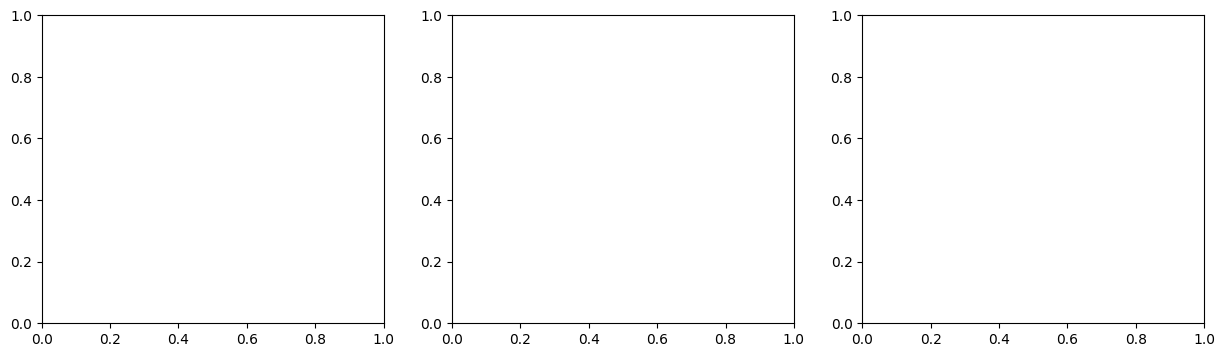

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Load balanced data
DATA_DIR = REAL_BASE_DIR / 'data/processed'
train_balanced = pd.read_csv(DATA_DIR / 'train_balanced_avocado.csv')

# Compare original vs augmented TDEs
original_tdes = train_balanced[(train_balanced['target']==1) & (train_balanced['is_augmented']==0)]
augmented_tdes = train_balanced[(train_balanced['target']==1) & (train_balanced['is_augmented']==1)]

# Critical TDE feature: color evolution rate
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Color evolution rate
axes[0].hist(original_tdes['color_evolution_rate'].dropna(), bins=30, alpha=0.5, label='Original')
axes[0].hist(augmented_tdes['color_evolution_rate'].dropna(), bins=30, alpha=0.5, label='Augmented')
axes[0].set_xlabel('Color Evolution Rate')
axes[0].legend()
axes[0].axvline(0, color='red', linestyle='--', label='Should be >0 for TDEs')

# Plot 2: Blue excess
axes[1].hist(original_tdes['blue_excess'].dropna(), bins=30, alpha=0.5, label='Original')
axes[1].hist(augmented_tdes['blue_excess'].dropna(), bins=30, alpha=0.5, label='Augmented')
axes[1].set_xlabel('Blue Excess (u-g color)')
axes[1].legend()

# Plot 3: Peak time delay (u before r?)
axes[2].hist(original_tdes['u_r_peak_delay'].dropna(), bins=30, alpha=0.5, label='Original')
axes[2].hist(augmented_tdes['u_r_peak_delay'].dropna(), bins=30, alpha=0.5, label='Augmented')
axes[2].set_xlabel('u-r Peak Delay (days)')
axes[2].legend()
axes[2].axvline(0, color='red', linestyle='--', label='u should peak before r')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'augmentation_quality_check.png', dpi=150)
print("Saved diagnostic plot")

Check if test redshift range extends beyond training


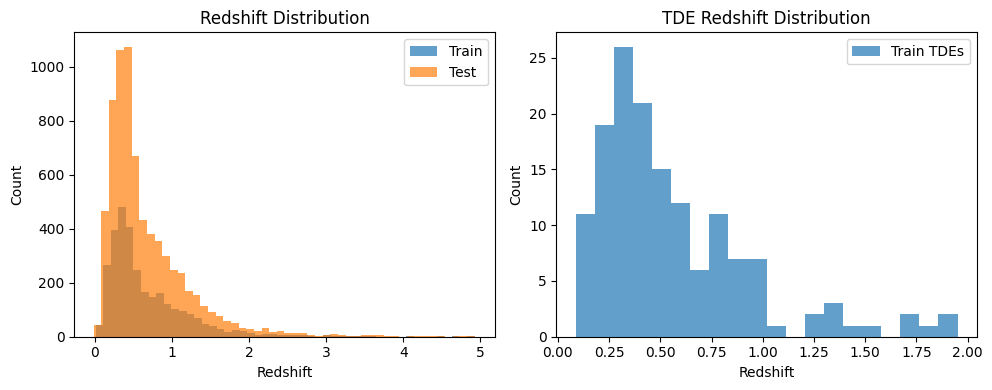

In [27]:
import matplotlib.pyplot as plt

train_log = pd.read_csv(BASE_DIR / 'train_log.csv')
test_log = pd.read_csv(BASE_DIR / 'test_log.csv')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(train_log['Z'], bins=50, alpha=0.7, label='Train')
plt.hist(test_log['Z'], bins=50, alpha=0.7, label='Test')
plt.xlabel('Redshift')
plt.ylabel('Count')
plt.legend()
plt.title('Redshift Distribution')

plt.subplot(1, 2, 2)
train_tdes = train_log[train_log['target'] == 1]
plt.hist(train_tdes['Z'], bins=20, alpha=0.7, label='Train TDEs')
plt.xlabel('Redshift')
plt.ylabel('Count')
plt.legend()
plt.title('TDE Redshift Distribution')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'redshift_distribution.png', dpi=150)
print("Check if test redshift range extends beyond training")